In [1]:
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models.video import r3d_18
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [6]:
DATASET_DIR = "/home/rwt/Documents/team-preoject-cellula/Shop DataSet"
CLASSES = ["non shop lifters", "shop lifters"]
NUM_FRAMES = 32   # Number of frames per video
RESIZE = 112      # Resize height/width
BATCH_SIZE = 4
EPOCHS = 10
LR = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


In [3]:
#   Video Dataset Class
# ====================================================
class VideoDataset(Dataset):
    def __init__(self, root_dir, classes, num_frames=16, transform=None):
        self.root_dir = root_dir
        self.classes = classes
        self.num_frames = num_frames
        self.transform = transform
        self.samples = []

        for label, cls in enumerate(classes):
            cls_dir = os.path.join(root_dir, cls)
            for file in os.listdir(cls_dir):
                if file.endswith(".mp4") or file.endswith(".avi"):
                    self.samples.append((os.path.join(cls_dir, file), label))

    def __len__(self):
        return len(self.samples)

    def read_video(self, path):
        cap = cv2.VideoCapture(path)
        frames = []
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
        cap.release()

        # Uniformly sample frames
        total = len(frames)
        if total == 0:
            return np.zeros((self.num_frames, RESIZE, RESIZE, 3), np.uint8)
        indices = np.linspace(0, total - 1, self.num_frames).astype(int)
        frames = [frames[i] for i in indices]

        return frames

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        frames = self.read_video(path)

        # Apply transform to each frame
        if self.transform:
            frames = [self.transform(frame) for frame in frames]

        # Stack frames -> [C, T, H, W]
        video = torch.stack(frames, dim=1)
        return video, label



In [7]:
#3- Transform & Dataloaders
# ====================================================
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((RESIZE, RESIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.45, 0.45, 0.45],
                         std=[0.225, 0.225, 0.225]),
])

#Split data (simple)
dataset = VideoDataset(DATASET_DIR, CLASSES, num_frames=NUM_FRAMES, transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_ds, test_ds = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)


loads a pretrained 3D convolutional neural network called ResNet-18 3D (R3D-18) from Torchvision’s video models — a model specifically designed for video classification.

In [8]:

# ====================================================
# 4️⃣  Model: 3D CNN (ResNet3D)
# ====================================================
model = r3d_18(weights="KINETICS400_V1")
model.fc = nn.Linear(model.fc.in_features, len(CLASSES))
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)


Downloading: "https://download.pytorch.org/models/r3d_18-b3b3357e.pth" to /home/rwt/.cache/torch/hub/checkpoints/r3d_18-b3b3357e.pth


100%|██████████| 127M/127M [02:10<00:00, 1.02MB/s] 


In [9]:

# ====================================================
# 5️⃣  Training Loop
# ====================================================
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for videos, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        videos, labels = videos.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(videos)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1} Loss: {total_loss/len(train_loader):.4f}")



Epoch 1/10: 100%|██████████| 171/171 [11:44<00:00,  4.12s/it]


Epoch 1 Loss: 0.2383


Epoch 2/10: 100%|██████████| 171/171 [11:22<00:00,  3.99s/it]


Epoch 2 Loss: 0.0498


Epoch 3/10: 100%|██████████| 171/171 [11:52<00:00,  4.16s/it]


Epoch 3 Loss: 0.0782


Epoch 4/10: 100%|██████████| 171/171 [07:20<00:00,  2.58s/it]


Epoch 4 Loss: 0.0475


Epoch 5/10: 100%|██████████| 171/171 [04:22<00:00,  1.53s/it]


Epoch 5 Loss: 0.0156


Epoch 6/10: 100%|██████████| 171/171 [04:17<00:00,  1.50s/it]


Epoch 6 Loss: 0.0037


Epoch 7/10: 100%|██████████| 171/171 [04:19<00:00,  1.52s/it]


Epoch 7 Loss: 0.0019


Epoch 8/10: 100%|██████████| 171/171 [04:23<00:00,  1.54s/it]


Epoch 8 Loss: 0.0020


Epoch 9/10: 100%|██████████| 171/171 [04:17<00:00,  1.51s/it]


Epoch 9 Loss: 0.0015


Epoch 10/10: 100%|██████████| 171/171 [04:16<00:00,  1.50s/it]

Epoch 10 Loss: 0.0027



✅ Test Accuracy: 98.83%
Confusion Matrix:
 [[104   2]
 [  0  65]]


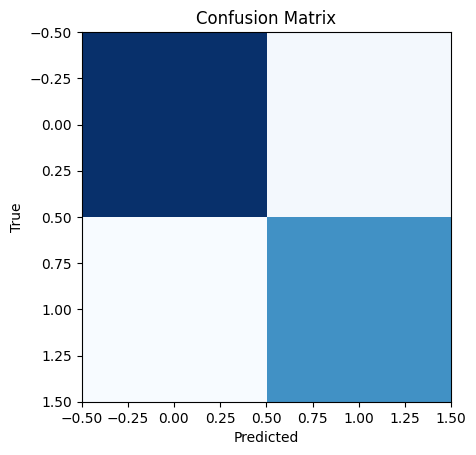

In [10]:
# ====================================================
# 6️⃣  Evaluation
# ====================================================
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for videos, labels in test_loader:
        videos, labels = videos.to(DEVICE), labels.to(DEVICE)
        outputs = model(videos)
        preds = torch.argmax(outputs, dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

acc = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

print(f"\n✅ Test Accuracy: {acc*100:.2f}%")
print("Confusion Matrix:\n", cm)

plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
